## **3D elastic VTI wave equation implementation on a staggered grid**

This is a first attempt at implementing the elastic wave equations in 3D vertical transversely isotropic (VTI) media as described in [1].

This notebook will attempt to implement this FD scheme and recreate the results from both Numerical examples [4.1] and [4.2].

<br> Chirayu Khimji 
<br> Independent Research Project 
<br> MSc Applied Computational Science and Engineering - Imperial College London 
<br> IRP Supervisors: Dr. Gerard Gorman + Dr. Rhodri Nelson


## Introduction

To be added in proper academic syntax


## Outline
this cell needs to be completed in more detail when tasks below are completed

1. Implement 3D elastic VTI wave propagation (Vectorized Approach) using temporal high-accuracy staggered-grid finite-difference scheme

2. Implement 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme i.e. like the paper [1].

3. Testing: Compare the resultants of these two implemenations to make sure everything works

## 3D Elastic VTI wave-equations
The paper expresses the elastic wave equations as a set of scalar PDEs in conventional velocity-stress format: 

$$
\begin{aligned}
\frac{\partial v_x}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z} \right) \\
\frac{\partial v_y}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z} \right) \\
\frac{\partial v_z}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{yz}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z} \right) \\
\frac{\partial \tau_{xx}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} - 2c_{66}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{yy}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} - 2c_{66}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{13}\frac{\partial v_{x}}{\partial x} + c_{13}\frac{\partial v_{y}}{\partial y} + c_{33}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial x} + c_{44}\frac{\partial v_{x}}{\partial z} \\
\frac{\partial \tau_{yz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial y} + c_{44}\frac{\partial v_{y}}{\partial z} \\
\frac{\partial \tau_{xy}}{\partial t} &= c_{66}\frac{\partial v_{y}}{\partial x} + c_{66}\frac{\partial v_{x}}{\partial y} \\
\end{aligned}
$$

Stiffness coefficients in elastic VTI media can be given by (Thomsen 1986):

$
\begin{aligned}
c_{11} &= \rho \left(1 + 2\epsilon\right)v_{p0}^{2} \\
c_{33} &= \rho v_{p0}^{2} \\
c_{44} &= \rho v_{s0}^{2} \\
c_{66} &= \rho \left(1 + 2\gamma\right)v_{s0}^{2} \\
c_{13} &= \rho v_{p0}^{2}\sqrt{f\left(f + 2\delta\right)} - \rho v_{s0}^{2} \\
f &= 1 - v_{s0}^{2}/v_{p0}^{2} \\
\end{aligned}
$




## Scalar PDEs converted into Vectorial form

Elastic Coefficient Matrix of the VTI Media medium [2]:

$C = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $

The elastic coefficient matrix of a VTI Media is taken into the vectorial form of the elastic wave equation in order to derive the Scalar PDEs given by the paper [1]. In order to easily implement $C$ into the Elastic Wave equations' vectorial form, we can disregard its zero elements and spilt $C$ into two distinct $(3$x$3)$ matrices $C_1$ and $C_2$:

$
\begin{aligned}
C_{1} &= \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} \\ c_{11} - 2c_{66} & c_{11} & c_{13} \\ c_{13} & c_{13} & c_{33} \end{bmatrix} \\ 
\\
C_{2} &= \begin{bmatrix}c_{44} & 0 & 0 \\ 0 & c_{44} & 0 \\ 0 & 0 & c_{66} \end{bmatrix}  \\
\\
\end{aligned}
$

Using $C_1$ and $C_2$, a higher-level representation of the scalar PDEs above can be derived from Hooke's law and the equation of motion:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = C_1 tr(\nabla v) \mathbf{I}  + C_2(\nabla v + (\nabla v)^T)
\end{cases}

since $tr(\nabla v)$ is the divergence of $v$ we can rewrite it as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d\tau}{dt} = C_1 \text{diag}(\nabla . v) + C_2 (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y, z) = \left( v_x(t, x, y, z), v_y(t, x, y, z), v_z(t, x, y, z) \right)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y, z) = \begin{bmatrix}\tau_{xx}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{xz}(t, x, y, z) \\\tau_{xy}(t, x, y, z) & \tau_{yy}(t, x, y, z) & \tau_{xy}(t, x, y, z) \\ \tau_{xz}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{zz}(t, x, y, z) \end{bmatrix}$


This representation provides a higher-level of abstraction and makes the implementation of this SG-FD scheme relatively simple using Devito's high-level tensorial types.



## Imports
all required imports used in this notebook are below for consistency.

In [2]:
# Required imports:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic import RickerSource, TimeAxis, Receiver
from examples.seismic import plot_image, plot_velocity, plot_perturbation
from examples.seismic import ModelElasticVTI
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
#configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'


## Instantiate the Devito grid for a three dimensional problem
define the grid the same as the 3D homogenous model described in 4.1. This still needs to be fixed below is a sample structure

In [3]:
# Define dimensions for the interior of the model
nx, ny, nz = 301, 301, 301
dx,dy,dz = 12.0, 12.0, 12.0          # Grid spacing in m
shape = (nx, ny, nz)                 # Number of grid points
spacing = (dx, dy, dz)               # Domain size is now 5 km by 5 km
origin = (0., 0., 0.)                # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = -0.10
gamma = -0.05

#initial conditions
npad = 20
vp = 3.5 #km/s
vs = 2.4 #km/s
rho= 2.6 #kg/m**3

so = 8 #spatial order
to = 2 #temporal order

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=vp, vs=vs, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl=npad)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("grid.shape;      ", model.grid.shape)
print("grid.origin;     ", model.grid.origin)
print("grid.spacing_map;", model.grid.spacing_map)
print("grid.extent;     ", model.grid.extent)

Operator `initdamp` generated in 0.19 s
  * lowering.Clusters: 0.08 s (42.7 %)
     * specializing.Clusters: 0.06 s (32.1 %)
  * lowering.IET: 0.06 s (32.1 %)
     * specializing.IET: 0.04 s (21.4 %)
  * lowering.Expressions: 0.05 s (26.7 %)
Flops reduction after symbolic optimization: [102 --> 102]
Allocating memory for damp(343, 343, 343)
Operator `initdamp` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/fb0e24072c3f9e91a7aeeac64e83260f0d67c54b.c` in 0.08 s from jit-cache
Operator `initdamp` run in 0.15 s
* section0<<341,341,341>,<20,341,341>,<20,341,341>,<341,20,341>,<341,20,341>,<341,341,20>,<341,341,20>> with OI=0.01 computed in 0.15 s [1.66 GFlops/s]
Performance[mode=advanced] arguments: {}
shape;            (301, 301, 301)
origin;           (0.0, 0.0, 0.0)
spacing;          (12.0, 12.0, 12.0)
extent;           (3600.0, 3600.0, 3600.0)

grid.shape;       (341, 341, 341)
grid.origin;      (o_x, o_y, o_z)
grid.spacing_map; {h_x: 12.0, h_y: 12.0, h_

In [4]:
# Now we create the velocity and pressure fields
# PDE fn's:
x, y, z = model.grid.dimensions
damp = model.damp

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic representation of the model grid spacing
s = model.grid.stepping_dim.spacing 

##to review
#Create the staggered grid updates
#t = model.grid.stepping_dim
#time = model.grid.time_dim

## Define the simulation time range


In [5]:
t0 = 0.     # Simulation time start
tn = 1000.  # Simulation time end (1 second = 1000 msec)

#dt = 1.2
dt = model.critical_dt #CFL condition

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min,max,dt,num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))

Time min,max,dt,num;   0.000000 1000.000000   1.683000 595


## Define the acquisition geometry: locations of explosive source and recievers

For Numercial Example [4.1] in [1]:
A 38 Hz center frequency Ricker wavelet source, located at (x, y, z) = (1800m, 1800m, 1800m) and is added into $v_x$ component to generate vibration.

For Ricker wavelet, the source signature $g(t)$ is the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Allocating memory for src(596, 1)
Allocating memory for src_coords(1, 3)
Allocating memory for rec_coords(301, 3)
src_coords [x,y,z]: [[1800. 1800. 1800.]]


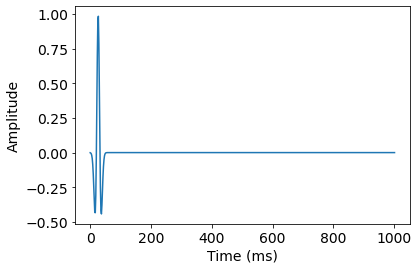

In [6]:
# Centered Source with 38 Hz center frequency
fpeak = 0.038
src = RickerSource(name='src', grid=model.grid, f0=fpeak, time_range=time_range)
src.coordinates.data[:] = np.array([1800., 1800., 1800.])

# line of receivers along right edge of model
## this needs to be fixed later on to be in line with the paper
rec = Receiver(name='rec', grid=model.grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:] = np.array([3600., 3600., 1800.])

print("src_coords [x,y,z]:", src.coordinates.data)
#print("rec_coords [x,y,z]:", rec.coordinates.data)

#plot time signature to view wavelet
src.show()


In [7]:
#source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*s)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*s)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*s)
src_term = src_xx + src_yy + src_zz

# Create interpolation expression for receivers
rec_term_no = rec.interpolate(expr=tau.forward)

irho = model.irho
ro = model.rho

##these coefficients are now computed by ModelElasticVTI
# Thomsen's stiffness coefficients in elastic VTI media from The stiffness matrix, otherwise known as the elastic modulus matrix
#c11 = ro*(1+2*eps)*vp**2
#c33 = ro*vp**2
#c44 = ro*vs**2
#c66 = ro*(1+2*gamma)*vs**2
#f = 1 - vs**2/vp**2
#c13 = ro*vp**2*sp.sqrt(f*(f+2*delta))-ro*vs**2

c11 = model.c11
c33 = model.c33
c44 = model.c44
c66 = model.c66
c13 = model.c13


#Assemble full C matrix for VTI media
C = np.diagflat([c11,c11,c33,c44,c44,c66])
C[0][1] = c11 - 2*c66
C[1][0] = C[0][1]
C[0][2] = c13
C[2][0] = C[0][2]
C[2][1] = C[0][2]
C[1][2] = C[2][1]


##for vectorial PDE
#Split full C matrix for VTI media
C1 = sp.Matrix([[c11, c11 - 2*c66, c13], [c11 - 2*c66, c11, c13], [c13, c13, c33]])
C2 = sp.Matrix([[c44, 0, 0], [0, c44, 0], [0, 0, c66]])



## Assemble scalar PDEs individually


In [8]:
# Particle Velocity for VTI Media for each direction
u_vx = Eq(v[0].forward, v[0] + s*irho*(tau[0].dx + tau[1].dy + tau[2].dz) )
u_vy = Eq(v[1].forward, v[1] + s*irho*(tau[3].dx + tau[4].dy + tau[5].dz) )
u_vz = Eq(v[2].forward, v[2] + s*irho*(tau[6].dx + tau[7].dy + tau[8].dz) )

# Stress equations:
u_txx = Eq(tau[0].forward, tau[0] + s*(c11*v[0].dx + c11*v[1].dy - 2*c66*v[1].dy + c13*v[2].dz) )
u_tyy = Eq(tau[4].forward, tau[4] + s*(c11*v[0].dx - 2*c66*v[0].dx + c11*v[1].dy + c13*v[2].dz) )
u_tzz = Eq(tau[8].forward, tau[8] + s*(c13*v[0].dx + c13*v[1].dy + c33*v[2].dz) )

u_txz = Eq(tau[2].forward, tau[2] + s*(c44*v[2].dx + c44*v[0].dz) )
u_tyz = Eq(tau[5].forward, tau[5] + s*(c44*v[2].dy + c44*v[1].dz) )
u_txy = Eq(tau[1].forward, tau[1] + s*(c66*v[1].dx + c66*v[0].dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

In [8]:
#Assemble the operator 
op_fwd = Operator(stencil + src_term, subs=model.spacing_map)

#Print generated c++ code
print(op_fwd)

#Forward Simulation
op_fwd(dt=dt)

MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  for (int time = time_m, t0 = (time)%(3), t1 = (time + 1)%(3); time <= time_M; time += 1, t0 = (time)%(3), t1 = (time + 1)%(3))
  {
    struct timeval start_section0, end_section0;
    gettimeofday(&start_section0, NULL);
    /* Begin section0 */
    bf0(c11,c13,c33,c44,c66,dt,irho,t_xx_vec,t_xy_vec,t_xz_vec,t_yy_vec,t_yz_vec,t_zz_vec,v_x_vec,v_y_vec,v_z_vec,t0,t1,x0_blk0_size,x_M - (x_M - x_m + 1)%(x0_blk0_size),x_m,y0_blk0_size,y_M - (y_M - y_m + 1)%(y0_blk0_size),y_m,z_M,z_m);
    bf0(c11,c13,c33,c44,c66,dt,irho,t_xx_vec,t_xy_vec,t_xz_vec,t_yy_vec,t_yz_vec,t_zz_vec,v_x_vec,v_y_vec,v_z_vec,t0,t1,x0_blk0_size,x_M - (x_M - x_m + 1)%(x0_blk0_size),x_m,(y_M - y_m + 1)%(y0_blk0_size),y_M,y_M - (y_M - y_m + 1)%(y0_blk0_size) + 1,z_M,z_m);
    bf0(c11,c13,c33,c44,c66,dt,irho,t_xx_vec,t_xy_vec,t_xz_vec,t_yy_vec,t_yz_vec,t_zz_vec,v_x_vec,v_y_vec,v_z_vec,t0,t1,(x_M - x_m + 1)%(x0_blk0_size),x_M,x_M - (x_M - x_m + 1)%(x0_blk0_size) + 1,y0_blk0_size,y_

## Assemble PDE in Vectorial form

In [ ]:
irho = 1/ro 

# Particle Velocity for VTI Media
u_v = Eq(v.forward, v + s*irho*div(tau))

# Stress Equation stencil for the elastic case needs to be fixed for Elastic VTI


#Assembles the PDE symbolically
#u_t = Eq(tau.forward, tau + s * C1*diag(div(v.forward)) + s * C2*(grad(v.forward) + grad(v.forward).T)) ##need to fix this line 
#stencil = [u_v] + [u_t]
print(type(diag(div(v.forward))))
print(type(tau))
print(type(C1))

In [9]:
#u_v check
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y, z), v_y(t + dt, x, y + h_y/2, z), v_z(t + dt, x, y, z + h_z/2)), Vector(dt*(Derivative(t_xx(t, x, y, z), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), y) + Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), z))/rho + v_x(t, x + h_x/2, y, z), dt*(Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), x) + Derivative(t_yy(t, x, y, z), y) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), z))/rho + v_y(t, x, y + h_y/2, z), dt*(Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), x) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), y) + Derivative(t_zz(t, x, y, z), z))/rho + v_z(t, x, y, z + h_z/2)))

In [11]:
#u_t check
u_t

In [12]:
#Forward Simulation
#op_fwd = Operator([u_v] + [u_t]  + src_term)
op_fwd()

In [ ]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

# References

[1] Xu, S. and Liu, Y., 2019. Modeling 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme. Journal of Applied Geophysics, 170, p.103847.

[2] Wang, Y., Mu, P., Duan, Y. and Wang, T., 2018. Numerical Simulation of Elastic Wave Equation and Analysis of Wave Field Characteristics in 2-D VTI Medium. Open Journal of Yangtze Oil and Gas, 3(03), p.153.
